# **Text Similarity**

In [ ]:
# documents
doc1, doc2='I like dogs.', 'I hate dogs.'

# Split the documents and create tokens
doc1_tokens=set(doc1.lower().split())
doc2_tokens=set(doc2.lower().split())

#Print the tokens
print(doc1_tokens,doc2_tokens)


# Calculate the Jaccard Similarity
jaccard_similarity=  len(doc1_tokens.intersection(doc2_tokens))/len(doc1_tokens.union(doc2_tokens))

# Print the Jaccard Simialrity score
print(jaccard_similarity)

{'like', 'i', 'dogs.'} {'hate', 'i', 'dogs.'}
0.5


In [ ]:
# Let's import text feature extraction TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Import Cosien Similarity metric
from sklearn.metrics.pairwise import cosine_similarity


docs=['I like dogs.', 'I hate dogs.']

# Create TFidfVectorizer 
tfidf= TfidfVectorizer()

# Fit and transform the documents 
tfidf_vector = tfidf.fit_transform(docs)

# Compute cosine similarity
cosine_sim=cosine_similarity(tfidf_vector, tfidf_vector)

# Print the cosine similarity
print(cosine_sim)

[[1.         0.33609693]
 [0.33609693 1.        ]]


In [ ]:
import numpy as np 
import pandas as pd

In [ ]:
from sklearn.model_selection import train_test_split

def read_data():
    df = pd.read_csv("/content/drive/MyDrive/train_similarity.csv", nrows=20000)
    print ("Shape of base training File = ", df.shape)
    # Remove missing values and duplicates from training data
    df.drop_duplicates(inplace=True)
    df.dropna(inplace=True)
    print("Shape of base training data after cleaning = ", df.shape)
    return df

df = read_data()
df_train, df_test = train_test_split(df, test_size = 0.02)
print (df_train.head(2))
print (df_test.shape)

Shape of base training File =  (20000, 6)
Shape of base training data after cleaning =  (20000, 6)
          id  ...  is_duplicate
5162    5162  ...             0
10600  10600  ...             0

[2 rows x 6 columns]
(400, 6)


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import re
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.stem.porter import *

words = re.compile(r"\w+",re.I)
stopword = stopwords.words('english')
stemmer = PorterStemmer()

def tokenize_questions(df):
    question_1_tokenized = []
    question_2_tokenized = []

    for q in df.question1.tolist():
        question_1_tokenized.append([stemmer.stem(i.lower()) for i in words.findall(q) if i not in stopword])

    for q in df.question2.tolist():
        question_2_tokenized.append([stemmer.stem(i.lower()) for i in words.findall(q) if i not in stopword])

    df["Question_1_tok"] = question_1_tokenized
    df["Question_2_tok"] = question_2_tokenized
    
    return df

def train_dictionary(df):
    
    questions_tokenized = df.Question_1_tok.tolist() + df.Question_2_tok.tolist()
    
    dictionary = corpora.Dictionary(questions_tokenized)
    dictionary.filter_extremes(no_below=5, no_above=0.8)
    dictionary.compactify()
    
    return dictionary
    
df_train = tokenize_questions(df_train)
dictionary = train_dictionary(df_train)
print ("No of words in the dictionary = %s" %len(dictionary.token2id))

df_test = tokenize_questions(df_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


No of words in the dictionary = 4827


In [ ]:
def get_vectors(df, dictionary):
    
    question1_vec = [dictionary.doc2bow(text) for text in df.Question_1_tok.tolist()]
    question2_vec = [dictionary.doc2bow(text) for text in df.Question_2_tok.tolist()]
    
    question1_csc = gensim.matutils.corpus2csc(question1_vec, num_terms=len(dictionary.token2id))
    question2_csc = gensim.matutils.corpus2csc(question2_vec, num_terms=len(dictionary.token2id))
    
    return question1_csc.transpose(),question2_csc.transpose()


q1_csc, q2_csc = get_vectors(df_train, dictionary)

print (q1_csc.shape)
print (q2_csc.shape)

(19600, 4827)
(19600, 4827)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity as cs
from sklearn.metrics.pairwise import manhattan_distances as md
from sklearn.metrics.pairwise import euclidean_distances as ed
from sklearn.metrics import jaccard_similarity_score as jsc
from sklearn.neighbors import DistanceMetric
from sklearn.preprocessing import MinMaxScaler

minkowski_dis = DistanceMetric.get_metric('minkowski')
mms_scale_man = MinMaxScaler()
mms_scale_euc = MinMaxScaler()
mms_scale_mink = MinMaxScaler()

def get_similarity_values(q1_csc, q2_csc):
    cosine_sim = []
    manhattan_dis = []
    eucledian_dis = []
    jaccard_dis = []
    minkowsk_dis = []
    
    for i,j in zip(q1_csc, q2_csc):
        sim = cs(i,j)
        cosine_sim.append(sim[0][0])
        sim = md(i,j)
        manhattan_dis.append(sim[0][0])
        sim = ed(i,j)
        eucledian_dis.append(sim[0][0])
        i_ = i.toarray()
        j_ = j.toarray()
        try:
            sim = jsc(i_,j_)
            jaccard_dis.append(sim)
        except:
            jaccard_dis.append(0)
            
        sim = minkowski_dis.pairwise(i_,j_)
        minkowsk_dis.append(sim[0][0])
    
    return cosine_sim, manhattan_dis, eucledian_dis, jaccard_dis, minkowsk_dis    


# cosine_sim = get_cosine_similarity(q1_csc, q2_csc)
cosine_sim, manhattan_dis, eucledian_dis, jaccard_dis, minkowsk_dis = get_similarity_values(q1_csc, q2_csc)
print ("cosine_sim sample= \n", cosine_sim[0:2])
print ("manhattan_dis sample = \n", manhattan_dis[0:2])
print ("eucledian_dis sample = \n", eucledian_dis[0:2])
print ("jaccard_dis sample = \n", jaccard_dis[0:2])
print ("minkowsk_dis sample = \n", minkowsk_dis[0:2])

eucledian_dis_array = np.array(eucledian_dis).reshape(-1,1)
manhattan_dis_array = np.array(manhattan_dis).reshape(-1,1)
minkowsk_dis_array = np.array(minkowsk_dis).reshape(-1,1)
    
manhattan_dis_array = mms_scale_man.fit_transform(manhattan_dis_array)
eucledian_dis_array = mms_scale_euc.fit_transform(eucledian_dis_array)
minkowsk_dis_array = mms_scale_mink.fit_transform(minkowsk_dis_array)

eucledian_dis = eucledian_dis_array.flatten()
manhattan_dis = manhattan_dis_array.flatten()
minkowsk_dis = minkowsk_dis_array.flatten()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


cosine_sim sample= 
 [0.40089186286863654, 0.8944271909999159]
manhattan_dis sample = 
 [9.0, 1.0]
eucledian_dis sample = 
 [3.0, 1.0]
jaccard_dis sample = 
 [0.25, 0.8]
minkowsk_dis sample = 
 [3.0, 1.0]


In [ ]:
from sklearn.metrics import log_loss

def calculate_logloss(y_true, y_pred):
    loss_cal = log_loss(y_true, y_pred)
    return loss_cal

q1_csc_test, q2_csc_test = get_vectors(df_test, dictionary)
y_pred_cos, y_pred_man, y_pred_euc, y_pred_jac, y_pred_mink = get_similarity_values(q1_csc_test, q2_csc_test)
y_true = df_test.is_duplicate.tolist()

y_pred_man_array = mms_scale_man.transform(np.array(y_pred_man).reshape(-1,1))
y_pred_man = y_pred_man_array.flatten()

y_pred_euc_array = mms_scale_euc.transform(np.array(y_pred_euc).reshape(-1,1))
y_pred_euc = y_pred_euc_array.flatten()

y_pred_mink_array = mms_scale_mink.transform(np.array(y_pred_mink).reshape(-1,1))
y_pred_mink = y_pred_mink_array.flatten()

logloss = calculate_logloss(y_true, y_pred_cos)
print ("The calculated log loss value on the test set for cosine sim is = %f" %logloss)

logloss = calculate_logloss(y_true, y_pred_man)
print ("The calculated log loss value on the test set for manhattan sim is = %f" %logloss)

logloss = calculate_logloss(y_true, y_pred_euc)
print ("The calculated log loss value on the test set for euclidean sim is = %f" %logloss)

logloss = calculate_logloss(y_true, y_pred_jac)
print ("The calculated log loss value on the test set for jaccard sim is = %f" %logloss)

logloss = calculate_logloss(y_true, y_pred_mink)
print ("The calculated log loss value on the test set for minkowski sim is = %f" %logloss)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


The calculated log loss value on the test set for cosine sim is = 1.165446
The calculated log loss value on the test set for manhattan sim is = 3.012677
The calculated log loss value on the test set for euclidean sim is = 2.588190
The calculated log loss value on the test set for jaccard sim is = 2.987232
The calculated log loss value on the test set for minkowski sim is = 2.588190


# **Text Clustering**

In [ ]:
pip install wikipedia

  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11696 sha256=6c7f40dcbba0591344eba518eb8774e05329e957baf011f09774dd9014b2a557
  Stored in directory: /root/.cache/pip/wheels/15/93/6d/5b2c68b8a64c7a7a04947b4ed6d89fb557dcc6bc27d1d7f3ba
Successfully built wikipedia


In [ ]:
import pandas as pd
import wikipedia
articles=['Data Science','Artificial intelligence','Deep Learning','European Central Bank','Data Analysis','Financial technology','International Monetary Fund','Basketball','Swimming','Running']
wiki_lst=[]
title=[]
for article in articles:
   print("loading content: ",article)
   wiki_lst.append(wikipedia.page(article).content)
   title.append(article)
print("examine content")


loading content:  Data Science
loading content:  Artificial intelligence
loading content:  Deep Learning
loading content:  European Central Bank
loading content:  Data Analysis
loading content:  Financial technology
loading content:  International Monetary Fund
loading content:  Basketball
loading content:  Swimming
loading content:  Running
examine content


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(wiki_lst)

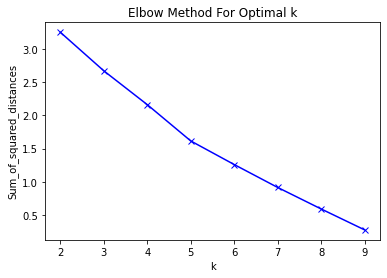

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   km = km.fit(X)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
labels=model.labels_
wiki_cl=pd.DataFrame(list(zip(title,labels)),columns=['title','cluster'])
print(wiki_cl.sort_values(by=['cluster']))

                         title  cluster
1      Artificial intelligence        0
2                Deep Learning        0
0                 Data Science        1
4                Data Analysis        1
3        European Central Bank        2
6  International Monetary Fund        2
8                     Swimming        3
5         Financial technology        4
7                   Basketball        5
9                      Running        5


Cluster: 0
Titles
 Artificial intelligence
           Deep Learning


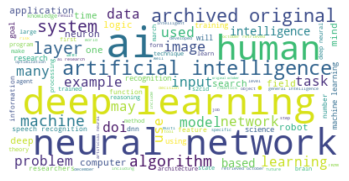

Cluster: 1
Titles
  Data Science
 Data Analysis


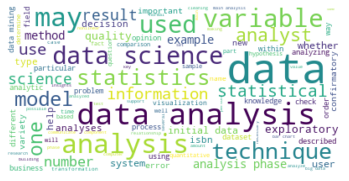

Cluster: 2
Titles
       European Central Bank
 International Monetary Fund


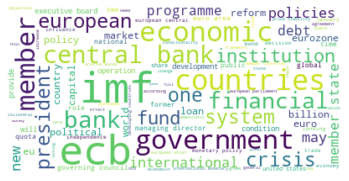

Cluster: 3
Titles
 Swimming


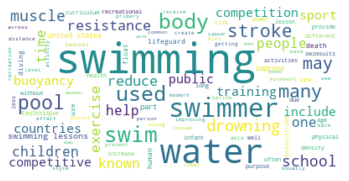

Cluster: 4
Titles
 Financial technology


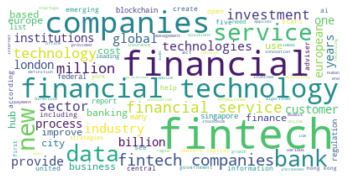

Cluster: 5
Titles
 Basketball
    Running


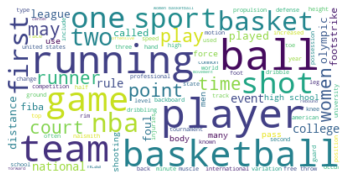

In [ ]:
from wordcloud import WordCloud
result={'cluster':labels,'wiki':wiki_lst}
result=pd.DataFrame(result)
for k in range(0,true_k):
   s=result[result.cluster==k]
   text=s['wiki'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   print('Titles')
   titles=wiki_cl[wiki_cl.cluster==k]['title']         
   print(titles.to_string(index=False))
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()